# Intro

- Goal: building a ReAct agent with memory using LangGraph.  
- Steps: start simple → add memory → add summarization → make it production-ready.
- Agent: can think, reason, and remember — just like a human assistant

#### ReAct Agent without Memory

Import Libraries

In [1]:
from langchain_openai import ChatOpenAI
import os
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START
from IPython.display import Image, display # type: ignore

- ChatOpenAI (gpt-4.1-nano) - fast, lightweight, ideal for demos.  
- set your API key.

In [2]:
llm = ChatOpenAI(temperature=0, model="gpt-4.1-nano", api_key=os.environ["OPENAI_API_KEY"]) # type: ignore

In [3]:
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CZrgJbRNTNPao8UlVcdhxYxaL5AX0', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e7248b41-1649-46b3-906f-d2d71d67e565-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Define Tool

- Introduce function to query Wikipedia.  
- Agent will call this automatically for factual data.  
- Example: world events, sports, or history.

In [4]:
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=1)) # type: ignore

In [5]:
def search_wikipedia(query: str) -> str:
    '''Searches Wikipedia for the given query and returns a summary of the results.
    Args:
        query (str): The search query.'''
    
    print("Wikipedia called with query: ", query)
    
    res = wikipedia.run(query)
    print("Results were successfully fetched from Wikipedia.")

    return res

Binding the Tool


- Combine the LLM and the Wikipedia tool.  
- Allows the model to “think and act.”  
- Keep it simple: no parallel calls yet.

In [6]:
llm_with_tools = llm.bind_tools([search_wikipedia], parallel_tool_calls=False)

Agent

- LangGraph models reasoning as nodes and edges.  
- Flow will control when the agent thinks vs. when it acts.  
- Flexibility with approach.

In [7]:
def call_llm(state : MessagesState) -> dict:
    response = llm_with_tools.invoke(state["messages"])
    return {"messages" : response}

builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_node("tools", ToolNode([search_wikipedia]))
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", tools_condition)
builder.add_edge("tools", "call_llm")
react_graph = builder.compile()

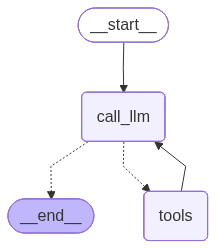

In [8]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

Running First Query 
- Agent calls Wikipedia and answers.  
- It works, but no memory yet.

In [9]:
msg = [HumanMessage(content="Where will the FIFA World Cup 2026 be held?")]
results = react_graph.invoke({"messages": msg}) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  FIFA World Cup 2026
Results were successfully fetched from Wikipedia.


'The FIFA World Cup 2026 will be jointly hosted by the United States, Canada, and Mexico.'

In [10]:
msg = [HumanMessage(content="What are scheduled dates?")]
results = react_graph.invoke({"messages": msg}) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  scheduled dates
Results were successfully fetched from Wikipedia.


'Scheduled dates refer to specific dates set in advance for an event or activity to take place. For example, in the context of executions in the United States, scheduled dates are the dates on which certain individuals are planned to be executed. Generally, scheduled dates are used to organize and plan events ahead of time.'

#### Add short-term memory

- Introduce InMemorySaver. 
- This lets the agent remember conversation context.  
- memory = smarter replies.

In [12]:
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()

In [13]:
react_graph_memory = builder.compile(checkpointer=memory)

In [14]:
config = {"configurable": {"thread_id": "1"}}

In [15]:
msg = [HumanMessage(content="Where will the FIFA World Cup 2026 be held?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  FIFA World Cup 2026
Results were successfully fetched from Wikipedia.


'The FIFA World Cup 2026 will be jointly hosted by the United States, Canada, and Mexico.'

In [16]:
msg = [HumanMessage(content="What are scheduled dates?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  FIFA World Cup 2026
Results were successfully fetched from Wikipedia.


'The FIFA World Cup 2026 is scheduled to take place from June 11 to July 19, 2026.'

#### Trim Messages

- Why trimming matters: long chats, token limits.  
- Keep only the most recent context.
- it helps debug and stay efficient.

In [17]:
from langchain_core.messages.utils import trim_messages, count_tokens_approximately

In [18]:
def pre_model_hook(state):
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=count_tokens_approximately,
        max_tokens=784,
        start_on="human",
        end_on=("human", "tool"),
    )

    print("********************Trimmed Messages START********************")
    for m in trimmed_messages:
        m.pretty_print()
    print("********************Trimmed Messages END********************")
    return trimmed_messages

def call_llm(state : MessagesState) -> dict:
    trimmed_messages = pre_model_hook(state)
    response = llm_with_tools.invoke(trimmed_messages)
    return {"messages" : response}


- Recompile with trimming + memory.  
- More scalable.

In [19]:
builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_node("tools", ToolNode([search_wikipedia]))
builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", tools_condition)
builder.add_edge("tools", "call_llm")

react_graph_memory = builder.compile(checkpointer=memory)

In [20]:
config = {"configurable": {"thread_id": "2"}}

In [21]:
msg = [HumanMessage(content="Where will the FIFA World Cup 2026 be held?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

********************Trimmed Messages START********************
================================ Human Message =================================

Where will the FIFA World Cup 2026 be held?
********************Trimmed Messages END********************
Wikipedia called with query:  FIFA World Cup 2026
Results were successfully fetched from Wikipedia.
********************Trimmed Messages START********************
================================ Human Message =================================

Where will the FIFA World Cup 2026 be held?
================================== Ai Message ==================================
Tool Calls:
  search_wikipedia (call_vVKNv01hAFHwpHgtqzeLAi8h)
 Call ID: call_vVKNv01hAFHwpHgtqzeLAi8h
  Args:
    query: FIFA World Cup 2026
================================= Tool Message =================================
Name: search_wikipedia

Page: 2026 FIFA World Cup
Summary: The 2026 FIFA World Cup, marketed as FIFA World Cup 26, will be the 23rd FIFA World Cup, the quadr

'The FIFA World Cup 2026 will be jointly hosted by three North American countries: the United States, Canada, and Mexico.'

In [22]:
msg = [HumanMessage(content="What are scheduled dates?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

********************Trimmed Messages START********************
================================ Human Message =================================

Where will the FIFA World Cup 2026 be held?
================================== Ai Message ==================================
Tool Calls:
  search_wikipedia (call_vVKNv01hAFHwpHgtqzeLAi8h)
 Call ID: call_vVKNv01hAFHwpHgtqzeLAi8h
  Args:
    query: FIFA World Cup 2026
================================= Tool Message =================================
Name: search_wikipedia

Page: 2026 FIFA World Cup
Summary: The 2026 FIFA World Cup, marketed as FIFA World Cup 26, will be the 23rd FIFA World Cup, the quadrennial international men's soccer championship contested by the national teams of the member associations of FIFA. The tournament will take place from June 11 to July 19, 2026. It will be jointly hosted by 16 cities in three North American countries; the main host country of matches is the United States, while Canada and Mexico will be the auxiliar

'Scheduled dates refer to the specific days or periods when an event or activity is planned to occur. For example, in the context of the 2026 FIFA World Cup, the tournament is scheduled to take place from June 11 to July 19, 2026.'

In [23]:
msg = [HumanMessage(content="In how many cities will it be hosted?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

********************Trimmed Messages START********************
================================ Human Message =================================

What are scheduled dates?
================================== Ai Message ==================================
Tool Calls:
  search_wikipedia (call_bWiVm2LfpJECUlsqYm7t5aEp)
 Call ID: call_bWiVm2LfpJECUlsqYm7t5aEp
  Args:
    query: FIFA World Cup 2026
================================= Tool Message =================================
Name: search_wikipedia

Page: 2026 FIFA World Cup
Summary: The 2026 FIFA World Cup, marketed as FIFA World Cup 26, will be the 23rd FIFA World Cup, the quadrennial international men's soccer championship contested by the national teams of the member associations of FIFA. The tournament will take place from June 11 to July 19, 2026. It will be jointly hosted by 16 cities in three North American countries; the main host country of matches is the United States, while Canada and Mexico will be the auxiliary hosts. The tourn

'The 2026 FIFA World Cup will be hosted in 16 cities.'

#### Remove Messages

- Reset conversation.  
- Use RemoveMessage example.  
- Useful for fresh starts.

In [24]:
from langchain_core.messages import RemoveMessage

def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        # remove the earliest two messages
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:2]]}

In [25]:
from langgraph.graph.message import REMOVE_ALL_MESSAGES

def delete_messages(state):
    return {"messages": [RemoveMessage(id=REMOVE_ALL_MESSAGES)]}

In [26]:
def call_llm(state : MessagesState) -> dict:
    updated_messages = delete_messages(state)
    response = llm_with_tools.invoke(updated_messages) # type: ignore
    return {"messages" : response}

#### Summarization

- Summarization as “compressed memory.”  
- Humans remember gist, not every detail.

In [ ]:
# !pip install -U langmem

- SummarizationNode auto-summarizes when tokens grow.  
- Emphasize it enables longer conversations.

In [27]:
from langmem.short_term import SummarizationNode

summarization_node = SummarizationNode( 
    token_counter=count_tokens_approximately,
    model=llm.bind(max_tokens=1024),
    max_tokens=1024,
    max_tokens_before_summary=256, 
)

In [28]:
from langchain_core.messages import AnyMessage, ToolMessage

class State(MessagesState):
    summarized_messages: list[AnyMessage]

In [33]:
prompt = (
    "You are an assistant for question-answering tasks. "
    "You are provided with a tool to which you can provide a query according to the user's question and it will search in wikipedia. "
    "Based on past information or summary answer the user's question. "
    "Based on summary so far provided, decide weather to call tool or you can answer directly."
    "past information: {info} \n"
)

In [34]:
def call_llm(state : State):

    llm_input = state["summarized_messages"]
    if type(state["messages"][-1]) == ToolMessage:
        llm_input += state["messages"][-1] # type: ignore

    formatted = prompt.format(info = llm_input)
    response = llm_with_tools.invoke(formatted)
    return {"messages" : [response]}

 - summarize → LLM → tool → back to summarize.  

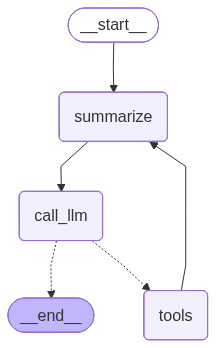

In [35]:
builder = StateGraph(State)
builder.add_node("summarize", summarization_node)
builder.add_node("call_llm", call_llm)
builder.add_node("tools", ToolNode([search_wikipedia]))
builder.add_edge(START, "summarize")
builder.add_edge("summarize", "call_llm")
builder.add_conditional_edges("call_llm", tools_condition)
builder.add_edge("tools", "summarize")

react_graph_memory = builder.compile(checkpointer=memory)
display(Image(react_graph_memory.get_graph().draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": "10"}}

In [37]:
msg = [HumanMessage(content="Where will fifa world cup 2026 will be hosted?")]

results = react_graph_memory.invoke({"messages": "Where will fifa world cup 2026 will be hosted?"}, config) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  FIFA World Cup 2026 host
Results were successfully fetched from Wikipedia.


'The 2026 FIFA World Cup will be jointly hosted by the United States, Canada, and Mexico. The United States will be the main host, with matches also taking place in Canada and Mexico. This will be the first World Cup hosted by three nations and will feature 48 teams.'

In [38]:
results

{'messages': [HumanMessage(content='Where will fifa world cup 2026 will be hosted?', additional_kwargs={}, response_metadata={}, id='2d7754be-87cc-4fb6-a541-a3a659e434ec'),
  HumanMessage(content='Where will fifa world cup 2026 will be hosted?', additional_kwargs={}, response_metadata={}, id='16a751b7-d9ab-4205-941c-dc6e0f671a7a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZjICZoQJawg0856X0fNi4MzL', 'function': {'arguments': '{"query":"FIFA World Cup 2026 host"}', 'name': 'search_wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 226, 'total_tokens': 248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1a97b5aa6c', 'id': 'chatcmpl-CZsjUOnaTB4kLIHAB7YNHRF5kGGX

In [39]:
msg = [HumanMessage(content="What are the scheduled dates?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

Wikipedia called with query:  FIFA World Cup 2026 schedule dates
Results were successfully fetched from Wikipedia.


'The FIFA World Cup 2026 will be held from June 11 to July 19, 2026.'

In [40]:
msg = [HumanMessage(content="how many cities are hosting it?")]
results = react_graph_memory.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

'The 2026 FIFA World Cup will be hosted in 16 cities across the United States, Canada, and Mexico.'

In [41]:
results

{'messages': [HumanMessage(content='Where will fifa world cup 2026 will be hosted?', additional_kwargs={}, response_metadata={}, id='2d7754be-87cc-4fb6-a541-a3a659e434ec'),
  HumanMessage(content='Where will fifa world cup 2026 will be hosted?', additional_kwargs={}, response_metadata={}, id='16a751b7-d9ab-4205-941c-dc6e0f671a7a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZjICZoQJawg0856X0fNi4MzL', 'function': {'arguments': '{"query":"FIFA World Cup 2026 host"}', 'name': 'search_wikipedia'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 226, 'total_tokens': 248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_1a97b5aa6c', 'id': 'chatcmpl-CZsjUOnaTB4kLIHAB7YNHRF5kGGX

#### Use in production

- persistence using SQLite. 
- Saves memory between runs — ideal for real apps.

In [42]:
import sqlite3

In [43]:
db_path = "example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [ ]:
# !pip install langgraph-checkpoint-sqlite

In [44]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [45]:
sqlite_react_graph = builder.compile(checkpointer=memory)

In [46]:
config = {"configurable": {"thread_id": "11"}}

In [47]:
msg = [HumanMessage(content="Where will the FIFA World Cup 2026 be held?")]
results = sqlite_react_graph.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

'The FIFA World Cup 2026 will be held across 16 cities in the United States, Canada, and Mexico. It will be the first time the tournament is hosted by three nations.'

In [48]:
msg = [HumanMessage(content="What are scheduled dates?")]
results = sqlite_react_graph.invoke({"messages": msg}, config) # type: ignore
results['messages'][-1].content

'The scheduled dates for the FIFA World Cup 2026 are from June 11 to July 19, 2026.'

In [49]:
graph_state = sqlite_react_graph.get_state(config) # type: ignore
for m in graph_state[0]['messages']:
    m.pretty_print()

================================ Human Message =================================

Where will the FIFA World Cup 2026 be held?
================================== Ai Message ==================================
Tool Calls:
  search_wikipedia (call_TKFbXLYNZWQZhZTWVySSOOP6)
 Call ID: call_TKFbXLYNZWQZhZTWVySSOOP6
  Args:
    query: FIFA World Cup 2026
================================= Tool Message =================================
Name: search_wikipedia

Page: 2026 FIFA World Cup
Summary: The 2026 FIFA World Cup, marketed as FIFA World Cup 26, will be the 23rd FIFA World Cup, the quadrennial international men's soccer championship contested by the national teams of the member associations of FIFA. The tournament will take place from June 11 to July 19, 2026. It will be jointly hosted by 16 cities in three North American countries; the main host country of matches is the United States, while Canada and Mexico will be the auxiliary hosts. The tournament will be the first to be hosted by three